In [167]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [168]:
import os

PATH = "/content/drive/MyDrive/datos_tfm/"
os.chdir(PATH)

In [169]:
import pandas as pd

StockPrices = pd.read_csv(PATH + 'MSFTPrices.csv', parse_dates=['Date'])
RandomPortfolios = pd.read_csv(PATH + 'EfficientFrontierPortfoliosSlim.csv')
FamaFrenchData = pd.read_csv(PATH + 'FamaFrenchFactors.csv', parse_dates=['Date'])
cum_rets = pd.read_csv(PATH + 'USO.csv', parse_dates=['Date'])
StockReturns = pd.read_csv(PATH + 'Big9Returns2017.csv', parse_dates=['Date'])

In finance, it is common to be working with a CSV (comma-separated-values) "flat" file of a timeseries of many different assets with their prices, returns, or other data over time.

In [170]:
# Import pandas as pd
import pandas as pd

# Ensure the prices are sorted by Date
StockPrices = StockPrices.sort_values(by='Date')

# Print only the first five rows of StockPrices
print(StockPrices.head())

        Date    Open    High     Low     Close    Volume   Adjusted
0 2000-01-03  88.777  89.722  84.712  58.28125  53228400  38.527809
1 2000-01-04  85.893  88.588  84.901  56.31250  54119000  37.226345
2 2000-01-05  84.050  88.021  82.726  56.90625  64059600  37.618851
3 2000-01-06  84.853  86.130  81.970  55.00000  54976600  36.358688
4 2000-01-07  82.159  84.901  81.166  55.71875  62013600  36.833828


The file you loaded includes daily Open, High, Low, Close, Adjusted Close, and Volume data, often referred to as OHLCV data.

The Adjusted Close column is the most important. It is normalized for stock splits, dividends, and other corporate actions, and is a true reflection of the return of the stock over time.

        Date    Open    High     Low     Close    Volume   Adjusted   Returns
0 2000-01-03  88.777  89.722  84.712  58.28125  53228400  38.527809       NaN
1 2000-01-04  85.893  88.588  84.901  56.31250  54119000  37.226345 -0.033780
2 2000-01-05  84.050  88.021  82.726  56.90625  64059600  37.618851  0.010544
3 2000-01-06  84.853  86.130  81.970  55.00000  54976600  36.358688 -0.033498
4 2000-01-07  82.159  84.901  81.166  55.71875  62013600  36.833828  0.013068


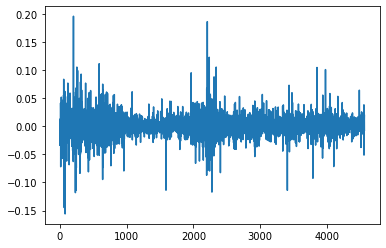

In [171]:
import matplotlib.pyplot as plt

# Calculate the daily returns of the adjusted close price
StockPrices['Returns'] = StockPrices['Adjusted'].pct_change()

# Check the first five rows of StockPrices
print(StockPrices.head())

# Plot the returns column over time
StockPrices['Returns'].plot()
plt.show()

In order to analyze the probability of outliers in returns, it is helpful to visualize the historical returns of a stock using a histogram.

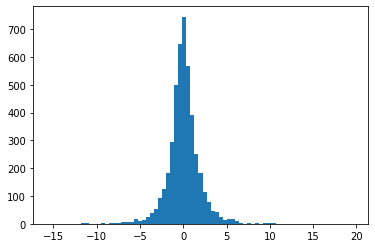

In [172]:
# Convert the decimal returns into percentage returns
percent_return = StockPrices['Returns']*100

# Drop the missing values
returns_plot = percent_return.dropna()

# Plot the returns histogram
plt.hist(returns_plot, bins=75)
plt.show()

When you are calculating the average daily return of a stock, you are essentially estimating the first moment of the historical returns distribution.

In [173]:
# Import numpy as np
import numpy as np

# Calculate the average daily return of the stock
mean_return_daily = np.mean(StockPrices['Returns'])
print(mean_return_daily)

# Calculate the implied annualized average return
mean_return_annualized = ((1+mean_return_daily)**252)-1
print(mean_return_annualized)

0.00037777546435757676
0.09985839482852632


We can also estimate the second moment or variance.

In [174]:
# Calculate the standard deviation of daily return of the stock
sigma_daily = np.std(StockPrices['Returns'])
print(sigma_daily)

# Calculate the daily variance
variance_daily = sigma_daily**2
print(variance_daily)

0.019341100408708317
0.00037407816501973704


You can't annualize the variance in the same way that you annualize the mean.

In this case, you will need to multiply the variance by the square root of the number of trading days in a year. There are typically 252 trading days in a calendar year. Let's assume this is the case for this exercise.

In [175]:
# Annualize the standard deviation
sigma_annualized = sigma_daily*np.sqrt(252)
print(sigma_annualized)

# Calculate the annualized variance
variance_annualized = sigma_annualized**2
print(variance_annualized)

0.3070304505826315
0.09426769758497373


Third moment: skewness

A negative skew is a right-leaning curve, while positive skew is a left-leaning curve. In finance, you would tend to want positive skewness, as this would mean that the probability of large positive returns is unusually high.

The third moment (skewness) of the stock returns is 0.22. A normal distribution would have a skewness much closer to 0.

In [176]:
# Import skew from scipy.stats
from scipy.stats import skew

# Drop the missing values
clean_returns = StockPrices['Returns'].dropna()

# Calculate the third moment (skewness) of the returns distribution
returns_skewness = skew(clean_returns)
print(returns_skewness)

0.21935459193067805


Fourth moment: kurtosis

The fourth moment (kurtosis) of the stock returns is 13.31 with an excess kurtosis of 10.31. A normal distribution would tend to have a kurtosis of 3, and an excess kurtosis of 0.

In [177]:
# Import kurtosis from scipy.stats
from scipy.stats import kurtosis

# Calculate the excess kurtosis of the returns distribution
excess_kurtosis = kurtosis(clean_returns)
print(excess_kurtosis)

# Derive the true fourth moment of the returns distribution
fourth_moment = excess_kurtosis + 3
print(fourth_moment)

10.314572618025519
13.314572618025519


In order to truly be confident in your judgement of the normality of the stock's return distribution, you will want to use a true statistical test rather than simply examining the kurtosis or skewness.

You can use the shapiro() function from scipy.stats to run a Shapiro-Wilk test of normality on the stock returns. The function will return two values in a list. The first value is the t-stat of the test, and the second value is the p-value. You can use the p-value to make a judgement about the normality of the data. If the p-value is less than or equal to 0.05, you can safely reject the null hypothesis of normality and assume that the data are non-normally distributed.

The p-value here is 0, so null hypothesis of normality is rejected. The data are non-normal.

In [178]:
# Import shapiro from scipy.stats
from scipy.stats import shapiro

# Run the Shapiro-Wilk test on the stock returns
shapiro_results = shapiro(clean_returns)
print("Shapiro results:", shapiro_results)

# Extract the p-value from the shapiro_results
p_value = shapiro_results[1]
print("P-value: ", p_value)

Shapiro results: ShapiroResult(statistic=0.9003633260726929, pvalue=0.0)
P-value:  0.0


In order to build and backtest a portfolio, you have to be comfortable working with the returns of multiple assets in a single object.

The model portfolio is constructed with pre-defined weights for some of the largest companies in the world just before January 2017.

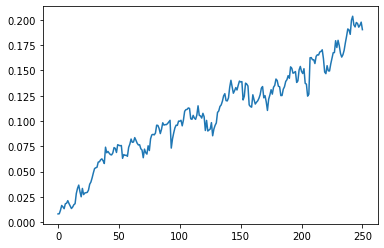

In [179]:
# Finish defining the portfolio weights as a numpy array
portfolio_weights = np.array([0.12, 0.15, 0.08, 0.05, 0.09, 0.10, 0.11, 0.14, 0.16])

# Calculate the weighted stock returns
StockReturns2 = StockReturns.drop('Date', axis=1)
WeightedReturns = StockReturns2.mul(portfolio_weights, axis=1)

# Calculate the portfolio returns
StockReturns['Portfolio'] = WeightedReturns.sum(axis=1)

# Plot the cumulative portfolio returns over time
CumulativeReturns = ((1+StockReturns["Portfolio"]).cumprod()-1)
CumulativeReturns.plot()
plt.show()

When comparing different portfolios, you often want to consider performance versus a naive equally-weighted portfolio.

You can expect equally-weighted portfolios to tend to outperform the market when the largest companies are doing poorly. This is because even tiny companies would have the same weight in your equally-weighted portfolio as Apple or Amazon, for example.

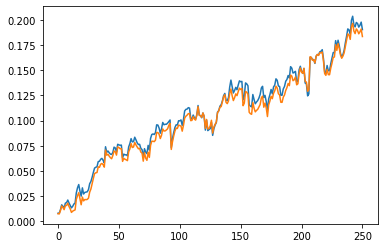

In [180]:
# How many stocks are in your portfolio?
numstocks = 9

# Create an array of equal weights across all assets
portfolio_weights_ew = np.repeat(1/numstocks, numstocks)

# Calculate the equally-weighted portfolio returns
StockReturns['Portfolio_EW'] = StockReturns2.iloc[:, 0:numstocks].mul(portfolio_weights_ew, axis=1).sum(axis=1)
CumulativeReturns = ((1+StockReturns["Portfolio"]).cumprod()-1)
CumulativeReturns.plot()
CumulativeReturns2 = ((1+StockReturns["Portfolio_EW"]).cumprod()-1)
CumulativeReturns2.plot()
plt.show()

Conversely, when large companies are doing well, market capitalization, or "market cap" weighted portfolios tend to outperform. This is because the largest weights are being assigned to the largest companies, or the companies with the largest market cap.

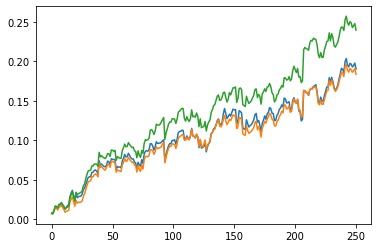

In [181]:
# Create an array of market capitalizations (in billions)
market_capitalizations = np.array([601.51, 469.25, 349.5, 310.48, 299.77, 356.94, 268.88, 331.57, 246.09])

# Calculate the market cap weights
mcap_weights = market_capitalizations / sum(market_capitalizations)

# Calculate the market cap weighted portfolio returns
StockReturns['Portfolio_MCap'] = StockReturns2.iloc[:, 0:9].mul(mcap_weights, axis=1).sum(axis=1)
CumulativeReturns = ((1+StockReturns["Portfolio"]).cumprod()-1)
CumulativeReturns.plot()
CumulativeReturns2 = ((1+StockReturns["Portfolio_EW"]).cumprod()-1)
CumulativeReturns2.plot()
CumulativeReturns3 = ((1+StockReturns["Portfolio_MCap"]).cumprod()-1)
CumulativeReturns3.plot()
plt.show()

The correlation matrix can be used to estimate the linear historical relationship between the returns of multiple assets.

                    AAPL      MSFT       XOM       JNJ       JPM      AMZN  \
AAPL            1.000000  0.437430  0.055505  0.038432  0.199914  0.509472   
MSFT            0.437430  1.000000  0.084108  0.230215  0.191248  0.621096   
XOM             0.055505  0.084108  1.000000  0.121012  0.305926  0.015118   
JNJ             0.038432  0.230215  0.121012  1.000000  0.070328  0.052781   
JPM             0.199914  0.191248  0.305926  0.070328  1.000000  0.013919   
AMZN            0.509472  0.621096  0.015118  0.052781  0.013919  1.000000   
GE              0.006766 -0.044827  0.193861  0.067930  0.257401 -0.092188   
FB              0.542367  0.543341 -0.046813  0.079391  0.095245  0.653030   
T               0.005082 -0.021079  0.197576  0.091622  0.252832 -0.017909   
Portfolio       0.653436  0.679864  0.290478  0.232015  0.462009  0.663011   
Portfolio_EW    0.641583  0.663890  0.350082  0.309194  0.504123  0.649387   
Portfolio_MCap  0.752686  0.723712  0.299451  0.273830  0.441217

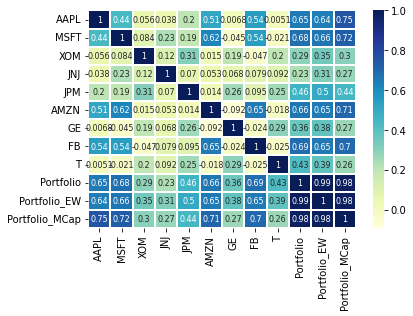

In [182]:
# Calculate the correlation matrix
correlation_matrix = StockReturns.corr()

# Print the correlation matrix
print(correlation_matrix)

# Import seaborn as sns
import seaborn as sns

# Create a heatmap
sns.heatmap(correlation_matrix,
            annot=True,
            cmap="YlGnBu", 
            linewidths=0.3,
            annot_kws={"size": 8})

# Plot aesthetics
plt.xticks(rotation=90)
plt.yticks(rotation=0) 
plt.show()

The correlation matrix doesn't really tell you anything about the variance of the underlying assets, only the linear relationships between assets. The co-variance (a.k.a. variance-covariance) matrix, on the other hand, contains all of this information, and is very useful for portfolio optimization and risk management purposes.

In [183]:
# Calculate the covariance matrix
cov_mat = StockReturns.cov()

# Annualize the co-variance matrix
cov_mat_annual = cov_mat*252

# Print the annualized co-variance matrix
print(cov_mat_annual)

                    AAPL      MSFT       XOM       JNJ       JPM      AMZN  \
AAPL            0.030996  0.011400  0.001093  0.000774  0.005716  0.018805   
MSFT            0.011400  0.021912  0.001392  0.003899  0.004597  0.019275   
XOM             0.001093  0.001392  0.012500  0.001548  0.005554  0.000354   
JNJ             0.000774  0.003899  0.001548  0.013092  0.001307  0.001266   
JPM             0.005716  0.004597  0.005554  0.001307  0.026371  0.000474   
AMZN            0.018805  0.019275  0.000354  0.001266  0.000474  0.043954   
GE              0.000236 -0.001315  0.004295  0.001540  0.008283 -0.003830   
FB              0.016243  0.013682 -0.000890  0.001545  0.002631  0.023290   
T               0.000152 -0.000530  0.003751  0.001780  0.006972 -0.000638   
Portfolio       0.010275  0.008988  0.002901  0.002371  0.006701  0.012415   
Portfolio_EW    0.009491  0.008257  0.003289  0.002973  0.006878  0.011439   
Portfolio_MCap  0.011914  0.009631  0.003010  0.002817  0.006442

Sharpe ratio is useful to determine how much risk is being taken to achieve a certain level of return. 

In finance, you are always seeking ways to improve your Sharpe ratio, and the measure is very commonly quoted and used to compare investment strategies.

In [184]:
# Risk free rate
risk_free = 0

# Calculate the Sharpe Ratio for each asset
RandomPortfolios['Sharpe'] = (RandomPortfolios['Returns'] - risk_free) / RandomPortfolios['Volatility']

# Print the range of Sharpe ratios
print(RandomPortfolios['Sharpe'].describe()[['min', 'max']])  # The portfolio historical Sharpe ratios range from 0.742 to 2.27.

min    0.742884
max    2.270462
Name: Sharpe, dtype: float64


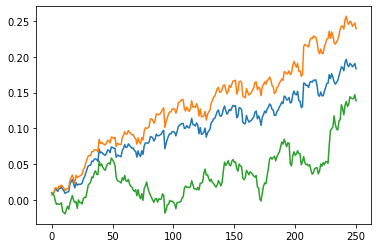

In [185]:
# Sort the portfolios by Sharpe ratio
sorted_portfolios = RandomPortfolios.sort_values(by=['Sharpe'], ascending=False)

# Extract the corresponding weights
MSR_weights = sorted_portfolios.iloc[0, 0:numstocks]

# Cast the MSR weights as a numpy array
MSR_weights_array = np.array(MSR_weights)

# Calculate the MSR portfolio returns
StockReturns['Portfolio_MSR'] = StockReturns2.iloc[:, 0:numstocks].mul(MSR_weights_array, axis=1).sum(axis=1)

# Plot the cumulative returns
CumulativeReturns = ((1+StockReturns["Portfolio_EW"]).cumprod()-1)
CumulativeReturns.plot()
CumulativeReturns2 = ((1+StockReturns["Portfolio_MCap"]).cumprod()-1)
CumulativeReturns2.plot()
CumulativeReturns3 = ((1+StockReturns["Portfolio_MSR"]).cumprod()-1)
CumulativeReturns3.plot()
plt.show()

The global minimum volatility portfolio, or GMV portfolio, is the portfolio with the lowest standard deviation (risk) and the highest return for the given risk level.

Returns are very hard to predict, but volatilities and correlations tend to be more stable over time. This means that the GMV portfolio often outperforms the MSR portfolios

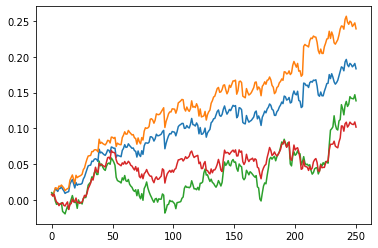

In [186]:
# Sort the portfolios by volatility
sorted_portfolios = RandomPortfolios.sort_values(by=['Volatility'], ascending=True)

# Extract the corresponding weights
GMV_weights = sorted_portfolios.iloc[0,0:numstocks]

# Cast the GMV weights as a numpy array
GMV_weights_array = np.array(GMV_weights)

# Calculate the GMV portfolio returns
StockReturns['Portfolio_GMV'] = StockReturns2.iloc[:, 0:numstocks].mul(GMV_weights_array, axis=1).sum(axis=1)

# Plot the cumulative returns
CumulativeReturns = ((1+StockReturns["Portfolio_EW"]).cumprod()-1)
CumulativeReturns.plot()
CumulativeReturns2 = ((1+StockReturns["Portfolio_MCap"]).cumprod()-1)
CumulativeReturns2.plot()
CumulativeReturns3 = ((1+StockReturns["Portfolio_MSR"]).cumprod()-1)
CumulativeReturns3.plot()
CumulativeReturns4 = ((1+StockReturns["Portfolio_GMV"]).cumprod()-1)
CumulativeReturns4.plot()
plt.show()

In order to perform a robust analysis on your portfolio returns, you must first subtract the risk-free rate of return from your portfolio returns. The portfolio return minus the risk-free rate of return is known as the Excess Portfolio Return. If the excess return is just slightly less, it is because the risk free rate is quite small.

Let's use now Fama model

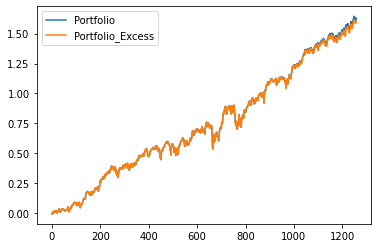

In [187]:
# Calculate excess portfolio returns
FamaFrenchData['Portfolio_Excess'] = FamaFrenchData['Portfolio'] - FamaFrenchData['RF']

# Plot returns vs excess returns
CumulativeReturns = ((1+FamaFrenchData[['Portfolio','Portfolio_Excess']]).cumprod()-1)
CumulativeReturns.plot()
plt.show()

Beta is an essential component of many financial models, and is a measure of systematic risk, or exposure to the broad market. 

In [188]:
# Calculate the co-variance matrix between Portfolio_Excess and Market_Excess
covariance_matrix = FamaFrenchData[['Portfolio_Excess', 'Market_Excess']].cov()

# Extract the co-variance co-efficient
covariance_coefficient = covariance_matrix.iloc[0, 1]
print(covariance_coefficient)

# Calculate the benchmark variance
benchmark_variance = FamaFrenchData['Market_Excess'].var()
print(benchmark_variance)

# Calculating the portfolio market beta
portfolio_beta = covariance_coefficient / benchmark_variance
print(portfolio_beta)

# Beta is 0.9738 , so for every 1.0% rise (or fall) in the market, you can expect your portfolio to rise (fall) roughly 0.97%.

5.726126338154964e-05
5.880335088211895e-05
0.9737755165745455


Calculating beta with CAPM

In [189]:
# Import statsmodels.formula.api
import statsmodels.formula.api as smf 

# Define the regression formula
CAPM_model = smf.ols(formula='Portfolio_Excess ~ Market_Excess', data=FamaFrenchData)

# Fit the regression
CAPM_fit = CAPM_model.fit()
print(CAPM_fit.rsquared_adj)

# Extract the beta
regression_beta = CAPM_fit.params['Market_Excess']
print(regression_beta)

0.7942627160017839
0.973775516574546


The Fama-French model famously adds two additional factors to the CAPM model to describe asset returns

In [190]:
# Import statsmodels.formula.api
import statsmodels.formula.api as smf 

# Define the regression formula
FamaFrench_model = smf.ols(formula='Portfolio_Excess ~ Market_Excess + SMB + HML', data=FamaFrenchData)

# Fit the regression
FamaFrench_fit = FamaFrench_model.fit()

# Extract the adjusted r-squared
regression_adj_rsq = FamaFrench_fit.rsquared_adj
print(regression_adj_rsq)

0.8193910088585152


 The Fama-French 3 factor model fit well, raising the adjusted r-squared from 0.7943 to 0.8194, meaning that the model explains more of your portfolio variance. But there's still room for improvement...

In [191]:
# Extract the p-value of the SMB factor
smb_pval = FamaFrench_fit.pvalues['SMB']

# If the p-value is significant, print significant
if smb_pval < 0.05:
    significant_msg = 'significant'
else:
    significant_msg = 'not significant'

# Print the SMB coefficient
smb_coeff = FamaFrench_fit.params['SMB']
print("The SMB coefficient is ", smb_coeff, " and is ", significant_msg)

The SMB coefficient is  -0.26215152743192643  and is  significant


This portfolio has a statistically significant negative exposure (-0.2621) to small-cap stocks - in other words - positive exposure to large caps!

As a curiosity, since 1982, value stocks have outperformed growth stocks in the majority of cases, and the tide often shifts during times of crisis and during bubbles such as the dot-com bubble during the late 1990's and early 2000's.

In [192]:
# Extract your portfolio alpha
portfolio_alpha = FamaFrench_fit.params['Intercept']
print(portfolio_alpha)

# Annualize your portfolio alpha
portfolio_alpha_annualized = ((1+portfolio_alpha)**252)-1
print(portfolio_alpha_annualized)

0.0001832666520318303
0.04726181730280854


Let's calculate the Fama 5-factor model. This is a more complex model whose adjusted r-squared is higher. 

In [193]:
# Import statsmodels.formula.api
import statsmodels.formula.api as smf 

# Define the regression formula
FamaFrench5_model = smf.ols(formula='Portfolio_Excess ~ Market_Excess + SMB + HML + RMW + CMA', data=FamaFrenchData)

# Fit the regression
FamaFrench5_fit = FamaFrench5_model.fit()

# Extract the adjusted r-squared
regression_adj_rsq = FamaFrench5_fit.rsquared_adj
print(regression_adj_rsq)

0.8367245019225793


The stock market tends to rise over time, but that doesn't mean that you won't have periods of drawdown.

Drawdown can be measured as the percentage loss from the highest cumulative historical point.

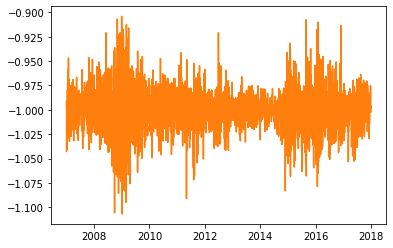

In [194]:
# Calculate the running maximum
cum_rets2 = cum_rets.drop('Date', axis=1)
running_max = np.maximum.accumulate(cum_rets2)

# Ensure the value never drops below 1
running_max[running_max < 1] = 1

# Calculate the percentage drawdown
drawdown = (cum_rets)/running_max - 1

# Plot the results
plt.plot(cum_rets['Date'], drawdown)
plt.show()

Drawdown is a measure of sustained losses over time, but what about simple single-day movements?

Value at Risk, often referred to as VaR, is a way to estimate the risk of a single day negative price movement. 

-3.608233764037496


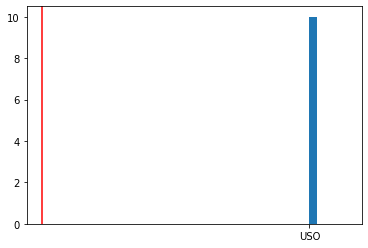

In [195]:
StockReturns_perc = cum_rets2
StockReturns_perc['USO'] = 100*StockReturns_perc['USO']

# Calculate historical VaR(95)
var_95 = np.percentile(StockReturns_perc, 5)
print(var_95)

# Sort the returns for plotting
sorted_rets = sorted(StockReturns_perc)

# Plot the probability of each sorted return quantile
plt.hist(sorted_rets, density=True, stacked=True)

# Denote the VaR 95 quantile
plt.axvline(x=var_95, color='r', linestyle='-', label='VaR 95: {0:.2f}%'.format(var_95))
plt.show()

Value at Risk can also be computed parametrically using a method known as variance/co-variance VaR. This method allows you to simulate a range of possibilities based on historical return distribution properties rather than actual return values.

In [196]:
# Import norm from scipy.stats
from scipy.stats import norm

# Estimate the average daily return
mu = np.mean(StockReturns2)

# Estimate the daily volatility
vol = np.std(StockReturns2)

# Set the VaR confidence level
confidence_level = 0.05

# Calculate Parametric VaR
var_95 = norm.ppf(confidence_level, mu, vol)
print('Mean: ', str(mu), '\nVolatility: ', str(vol), '\nVaR(95): ', str(var_95))

Mean:  AAPL    0.001637
MSFT    0.001405
XOM    -0.000130
JNJ     0.000897
JPM     0.000997
AMZN    0.001856
GE     -0.002152
FB      0.001763
T      -0.000106
dtype: float64 
Volatility:  AAPL    0.011068
MSFT    0.009306
XOM     0.007029
JNJ     0.007194
JPM     0.010209
AMZN    0.013181
GE      0.012458
FB      0.010694
T       0.010675
dtype: float64 
VaR(95):  [-0.0165694  -0.01390218 -0.01169161 -0.01093551 -0.01579565 -0.01982375
 -0.02264449 -0.01582797 -0.01766494]


The VaR(95) number calculated in previous exercises is simply the value at risk for a single day. To estimate the VaR for a longer time horizon, scale the value by the square root of time, similar to scaling volatility

In [197]:
var_95

array([-0.0165694 , -0.01390218, -0.01169161, -0.01093551, -0.01579565,
       -0.01982375, -0.02264449, -0.01582797, -0.01766494])

In [198]:
# Aggregate forecasted VaR
forecasted_values = np.empty([100, 2])

# Loop through each forecast period
for i in range(0, 100):
    # Save the time horizon i
    forecasted_values[i, 0] = i
    forecasted_values[i, 1] = var_95[0]*np.sqrt(i+1)   # We can choose from any of the VaR values from the StockReturns columns
forecasted_values

array([[ 0.00000000e+00, -1.65694008e-02],
       [ 1.00000000e+00, -2.34326713e-02],
       [ 2.00000000e+00, -2.86990440e-02],
       [ 3.00000000e+00, -3.31388016e-02],
       [ 4.00000000e+00, -3.70503065e-02],
       [ 5.00000000e+00, -4.05865773e-02],
       [ 6.00000000e+00, -4.38385139e-02],
       [ 7.00000000e+00, -4.68653426e-02],
       [ 8.00000000e+00, -4.97082024e-02],
       [ 9.00000000e+00, -5.23970460e-02],
       [ 1.00000000e+01, -5.49544854e-02],
       [ 1.10000000e+01, -5.73980881e-02],
       [ 1.20000000e+01, -5.97418242e-02],
       [ 1.30000000e+01, -6.19970209e-02],
       [ 1.40000000e+01, -6.41730133e-02],
       [ 1.50000000e+01, -6.62776032e-02],
       [ 1.60000000e+01, -6.83173896e-02],
       [ 1.70000000e+01, -7.02980140e-02],
       [ 1.80000000e+01, -7.22243436e-02],
       [ 1.90000000e+01, -7.41006130e-02],
       [ 2.00000000e+01, -7.59305334e-02],
       [ 2.10000000e+01, -7.77173786e-02],
       [ 2.20000000e+01, -7.94640546e-02],
       [ 2.

Stochastic or random movements are used in physics to represent particle and fluid movements, in mathematics to describe fractal behavior, and in finance to describe stock market movements.

In [199]:
print(StockReturns2.columns)

Index(['AAPL', 'MSFT', 'XOM', 'JNJ', 'JPM', 'AMZN', 'GE', 'FB', 'T'], dtype='object')


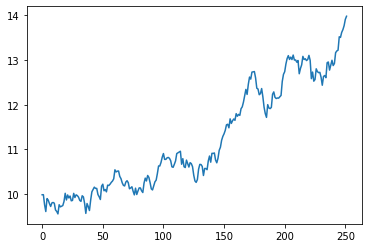

In [200]:
# Set the simulation parameters, for one of the columns of StockReturns table, which represents a given company
mu = np.mean(StockReturns2['JPM'])
vol = np.std(StockReturns2['JPM'])
T = 252
S0 = 10

# Add one to the random returns
rand_rets = np.random.normal(mu, vol, T) + 1

# Forecasted random walk
forecasted_values = S0*rand_rets.cumprod()

# Plot the random walk
plt.plot(range(0, T), forecasted_values)
plt.show()

Monte-Carlo simulations are used to model a wide range of possibilities.

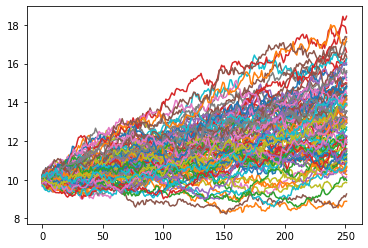

In [201]:
# Loop through 100 simulations
for i in range(100):

    # Generate the random returns
    rand_rets = np.random.normal(mu,vol,T) + 1
    
    # Create the Monte carlo path
    forecasted_values = S0*(rand_rets).cumprod()
    
    # Plot the Monte Carlo path
    plt.plot(range(T), forecasted_values)

# Show the simulations
plt.show()

Both the return values and the Monte-Carlo paths can be used for analysis of everything ranging from option pricing models and hedging to portfolio optimization and trading strategies.

In [202]:
# Aggregate the returns
sim_returns = []

# Loop through 100 simulations
for i in range(100):

    # Generate the Random Walk
    rand_rets = np.random.normal(mu, vol, T)
    
    # Save the results
    sim_returns.append(rand_rets)

# Calculate the VaR(99)
var_99 = np.percentile(sim_returns, 1)
print("Parametric VaR(99): ", round(100*var_99, 2),"%")

Parametric VaR(99):  -2.28 %
